
✅ Best PID parameters found:
Kp = 0.01000, Ki = 0.01000, Kd = 0.00000


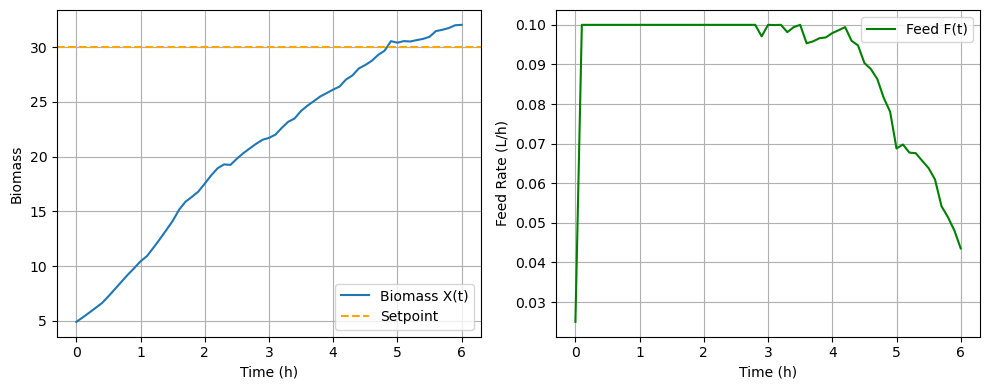

np.float64(57.55967653927669)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
# ---- RK4 Integrator ----
def rk4_step(model, y, t,F, h=0.001):
    k1 = np.array(model(t, y, F))
    k2 = np.array(model(t + h/2, y + h/2 * k1, F))
    k3 = np.array(model(t + h/2, y + h/2 * k2, F))
    k4 = np.array(model(t + h, y + h * k3, F))
    return y + (h / 6) * (k1 + 2*k2 + 2*k3 + k4)

# ---- PID Class (with Anti-windup) ----
class PID:
    def __init__(self, params, set_point, F_bnds):
        self.Kp, self.Ki, self.Kd = params
        self.set = set_point
        self.integral = 0
        self.previous = 0
        self.F_min, self.F_max = F_bnds

    def update(self, X, dt):
        err = self.set - X
        self.integral += err * dt
        der_err = (err - self.previous) / dt

        output = self.Kp * err + self.Ki * self.integral + self.Kd * der_err
        output_clipped = np.clip(output, self.F_min, self.F_max)

        if output != output_clipped:
            self.integral -= err * dt  # Anti-windup
        self.previous = err
        return output_clipped

# ---- Simulation Settings ----
dt = 0.1
T_final = 6.0
SS = int(T_final / dt)

# ---- System Constants ----
# Constants for the bioreactor model
F0 = 0.025
mu_max = 0.8564       # 1/h
Ks = 0.1707           # g/L
Yxs = 0.4066          # g/g
Sin = 286.0           # g/L
V0 = 1.7              # L, initial volume
X0 = 4.9              # g/L, initial biomass
S0 = 1.673            # g/L, initial substrate
F0 = 0.1              # L/h
K_I = 33              # Inhibition constant
K_D = 0.03            # Decay coefficient

# ---- Bioreactor Model ----
def actual_model(t, y, F):
    X, S, V = y
    S = max(S, 0)
    mu = mu_max * S / (Ks + S + S**2 / K_I)
    dX_dt = mu * X - (F / V) * X - K_D * X
    dS_dt = -(1 / Yxs) * mu * X + (F / V) * (Sin - S)
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]

# ---- Cost Function for Optimization ----
def pid_cost_function(params, set_point=30.0, plot=False):
    controller = PID(params, set_point, F_bnds=(0, 0.1))

    X = np.zeros(SS + 1)
    S = np.zeros(SS + 1)
    V = np.zeros(SS + 1)
    F_PID = np.zeros(SS + 1)

    X[0], S[0], V[0], F_PID[0] = X0, S0, V0, F0

    for step in range(SS):
        t = step * dt
        X_measured = X[step]#+np.random.normal(0, X[step]*0.05)  # Simulated measurement noise
        F = controller.update(X_measured, dt)
        F_PID[step+1] = F
        sol = solve_ivp(
            actual_model, (t, t+dt), [X[step], S[step], V[step]], args=(F,),
            method='RK45'
        )
        X[step+1], S[step+1], V[step+1] = sol.y[:, -1]
        X[step+1] += np.random.normal(0, X[step+1] * 0.008) # Change the biomass noise ratio to 0.8% for the measured data, because is more accurate.
        S[step+1] += np.random.normal(0, max(1e-6,S[step+1] * 0.03)) # Adding the max(1e-6, X[step] * ratio) to avoid division-by-zero or zero noise if biomass is momentarily near 0.

    t_vals = np.linspace(0, SS * dt, SS + 1)
    error = np.abs(X - set_point)
    iae = np.trapezoid(error, t_vals)
    control_effort = np.sum(np.diff(F_PID)**2)
    cost = iae + 10 * control_effort

    if plot:
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(t_vals, X, label='Biomass X(t)')
        plt.axhline(set_point, linestyle='--', color='orange', label='Setpoint')
        plt.xlabel("Time (h)"); plt.ylabel("Biomass")
        plt.legend(); plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(t_vals, F_PID, label='Feed F(t)', color='green')
        plt.xlabel("Time (h)"); plt.ylabel("Feed Rate (L/h)")
        plt.legend(); plt.grid(True)

        plt.tight_layout()
        plt.show()

    return cost

# ---- Optimize PID ----
initial_guess = [0.01, 0.01, 0]
bounds = [(0, 1), (0, 1), (0, 0.05)]

result = minimize(
    pid_cost_function,
    initial_guess,
    bounds=bounds,
    method='L-BFGS-B',
    options={'maxiter': 40, 'disp': True}
)

print("\n✅ Best PID parameters found:")
print(f"Kp = {result.x[0]:.5f}, Ki = {result.x[1]:.5f}, Kd = {result.x[2]:.5f}")

# ---- Final Simulation with Plot ----
pid_cost_function(result.x, plot=True)
